In [33]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [34]:
# Data preparation
csv_path = 'datasets\SN_m_tot_V2.0.csv'

df = pd.read_csv(csv_path, sep=';', header=None, names=["Year", "Month", "Frac_Date", "Sn_mean", "Sn_stdev", "Obs_n", "marker"])
df["Year_Month"] = df.pop("Year").astype(str) + "." + df.pop("Month").astype(str)

date_time = pd.to_datetime(df.pop('Year_Month'), format='%Y.%m')
df.tail()

,Frac_Date,Sn_mean,Sn_stdev,Obs_n,marker
3305,2024.455,164.1,21.4,1186,1
3306,2024.540,196.5,23.3,1044,0
3307,2024.624,215.5,24.8,1110,0
3308,2024.706,141.4,19.4,911,0
3309,2024.791,166.4,23.9,893,0


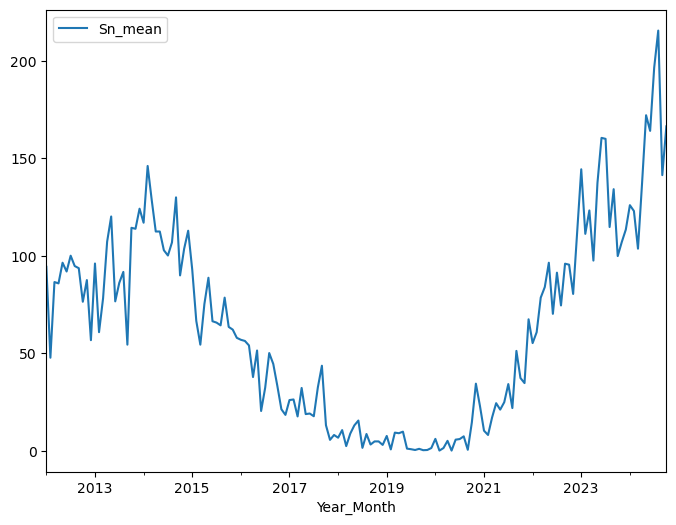

In [35]:
# # plot all available data
plot_cols = ['Sn_mean']
# plot_features = df[plot_cols]
# plot_features.index = date_time # gives labels that identify each row
# _ = plot_features.plot(subplots=True)

# plot a range of data
start_date = '2012-01'
plot_features = df[plot_cols][date_time >= start_date]
plot_features.index = date_time[date_time >= start_date]
_ = plot_features.plot(subplots=True)

In [36]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Frac_Date,3310.0,1886.914659,79.638228,1749.042,1817.979,1886.916,1955.853,2024.791
Sn_mean,3310.0,81.993716,67.706472,0.000,24.200,68.000,122.700,398.200
Sn_stdev,3310.0,5.686193,5.355646,-1.000,-0.750,5.400,9.500,29.400
Obs_n,3310.0,119.823565,254.120041,-1.000,-0.750,30.000,31.000,1587.000
marker,3310.0,0.998792,0.034747,0.000,1.000,1.000,1.000,1.000


In [37]:
Sn_stdev = df['Sn_stdev']
bad_Sn_stdev = Sn_stdev == -1.0
Sn_stdev[bad_Sn_stdev] = 0.0

Obs_n = df['Obs_n']
bad_Obs_n = Obs_n == -1.0
Obs_n[bad_Obs_n] = 0.0

df.describe().transpose()

C:\Users\HP\AppData\Local\Temp\ipykernel_1644\1840399840.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sn_stdev[bad_Sn_stdev] = 0.0
C:\Users\HP\AppData\Local\Temp\ipykernel_1644\1840399840.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Obs_n[bad_Obs_n] = 0.0


,count,mean,std,min,25%,50%,75%,max
Frac_Date,3310.0,1886.914659,79.638228,1749.042,1817.979,1886.916,1955.853,2024.791
Sn_mean,3310.0,81.993716,67.706472,0.000,24.200,68.000,122.700,398.200
Sn_stdev,3310.0,5.936344,5.052173,0.000,0.000,5.400,9.500,29.400
Obs_n,3310.0,120.073716,254.001410,0.000,0.000,30.000,31.000,1587.000
marker,3310.0,0.998792,0.034747,0.000,1.000,1.000,1.000,1.000


In [38]:
print(date_time)

0      1749-01-01
1      1749-02-01
2      1749-03-01
3      1749-04-01
4      1749-05-01
          ...    
3305   2024-06-01
3306   2024-07-01
3307   2024-08-01
3308   2024-09-01
3309   2024-10-01
Name: Year_Month, Length: 3310, dtype: datetime64[ns]


In [39]:
# dtype: datetime64[ns] to Unix timestamp in seconds
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60 # 24 hours * 60 mins * 60 seconds
year = (365.2425)*day

df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

df.tail()

,Frac_Date,Sn_mean,Sn_stdev,Obs_n,marker,Year sin,Year cos
3305,2024.455,164.1,21.4,1186,1,0.504156,-0.863612
3306,2024.540,196.5,23.3,1044,0,0.012321,-0.999924
3307,2024.624,215.5,24.8,1110,0,-0.497717,-0.867339
3308,2024.706,141.4,19.4,911,0,-0.869530,-0.493879
3309,2024.791,166.4,23.9,893,0,-1.000000,-0.000462


Text(0.5, 1.0, 'Time of year signal')

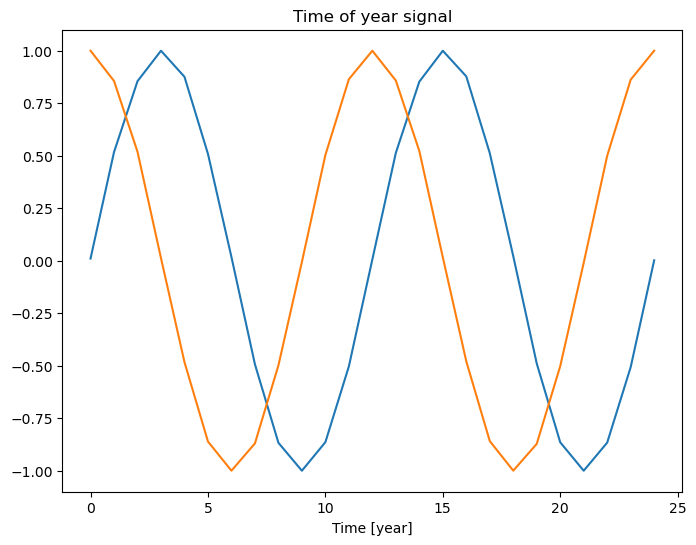

In [40]:
plt.plot(np.array(df['Year sin'])[:25])
plt.plot(np.array(df['Year cos'])[:25])
plt.xlabel('Time [year]')
plt.title('Time of year signal')

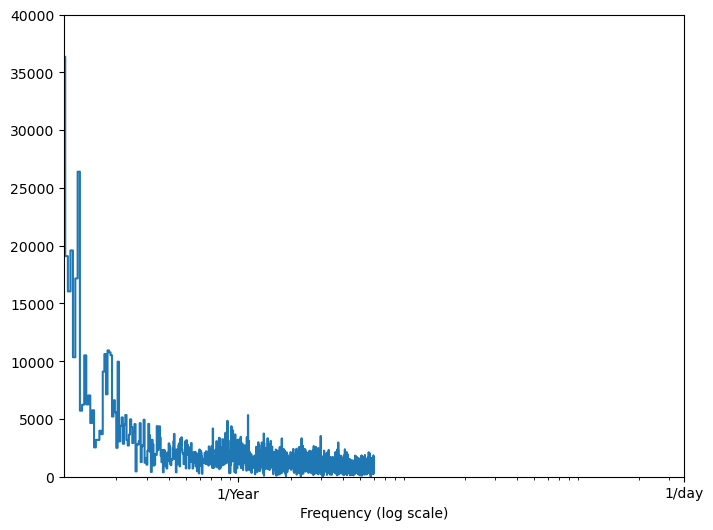

In [43]:
# convert the time-domain signal (Sn_mean over time)
# into its frequency-domain representation
fft = tf.signal.rfft(df['Sn_mean']) # computes the real-valued FFT

# create an array of indices corresponding to the frequency bins of the FFT output.
f_per_dataset = np.arange(0, len(fft))

n_samples_m = len(df['Sn_mean']) # total no. of monthly Sn_mean samples
months_per_year = 12
years_per_dataset = n_samples_m / months_per_year

# converts the FFT frequency bins (f_per_dataset)
# into frequencies expressed as cycles per year.
f_per_year = f_per_dataset / years_per_dataset

plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim(0.1, max(plt.xlim()))
plt.xticks([1, 365.2425], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')